In [6]:
# disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
import os
import sys

# define the notebook path to the '..
sys.path.insert(0, os.path.abspath('..'))

from collections import defaultdict
from joblib import load
import pandas as pd
import pymongo
import tqdm
import matplotlib.pyplot as plt

from src.analyzer import Model


In [8]:
df_replays = pd.read_csv('../data/test.csv')
print(df_replays['playlist_id'].value_counts())


playlist_id
ranked-doubles     2992
ranked-duels       2992
ranked-standard    2992
Name: count, dtype: int64


In [9]:
df_replays = df_replays[df_replays['playlist_id'] == 'ranked-doubles']
df_replays.shape

(2992, 96)

In [10]:
cluster = pymongo.MongoClient("mongodb://localhost:27017/")
database = cluster.get_database("rl_replays")

In [11]:
models = {}
replays = []
for i, r in tqdm.tqdm(df_replays.iterrows(), total=df_replays.shape[0], desc='Analyzing replays'):
    id = r['replay_id']
    replay = database.replays.find_one({'id': id})
    if replay is None: continue
    if r['playlist_id'] not in models:
        models[r['playlist_id']] = Model.get_model(r['playlist_id'])

    model = models[r['playlist_id']]

    model.analyze(replay)
    replays.append(replay)

Analyzing replays:   4%|▎         | 111/2992 [00:05<02:31, 19.02it/s]


KeyboardInterrupt: 

In [ ]:
tiers = []
predictions = []
for r in tqdm.tqdm(replays, total=len(replays), desc='Predicting ranks'):
    for team in ['blue', 'orange']:
        for player in r[team]['players']:
            if 'predict' not in player: continue
            tiers.append(r['min_rank']['tier'])
            predictions.append(player['predict']['tier'])

Predicting ranks: 100%|██████████| 2992/2992 [00:00<00:00, 205387.11it/s]


In [ ]:
df = pd.DataFrame({'tier': tiers, 'prediction': predictions})

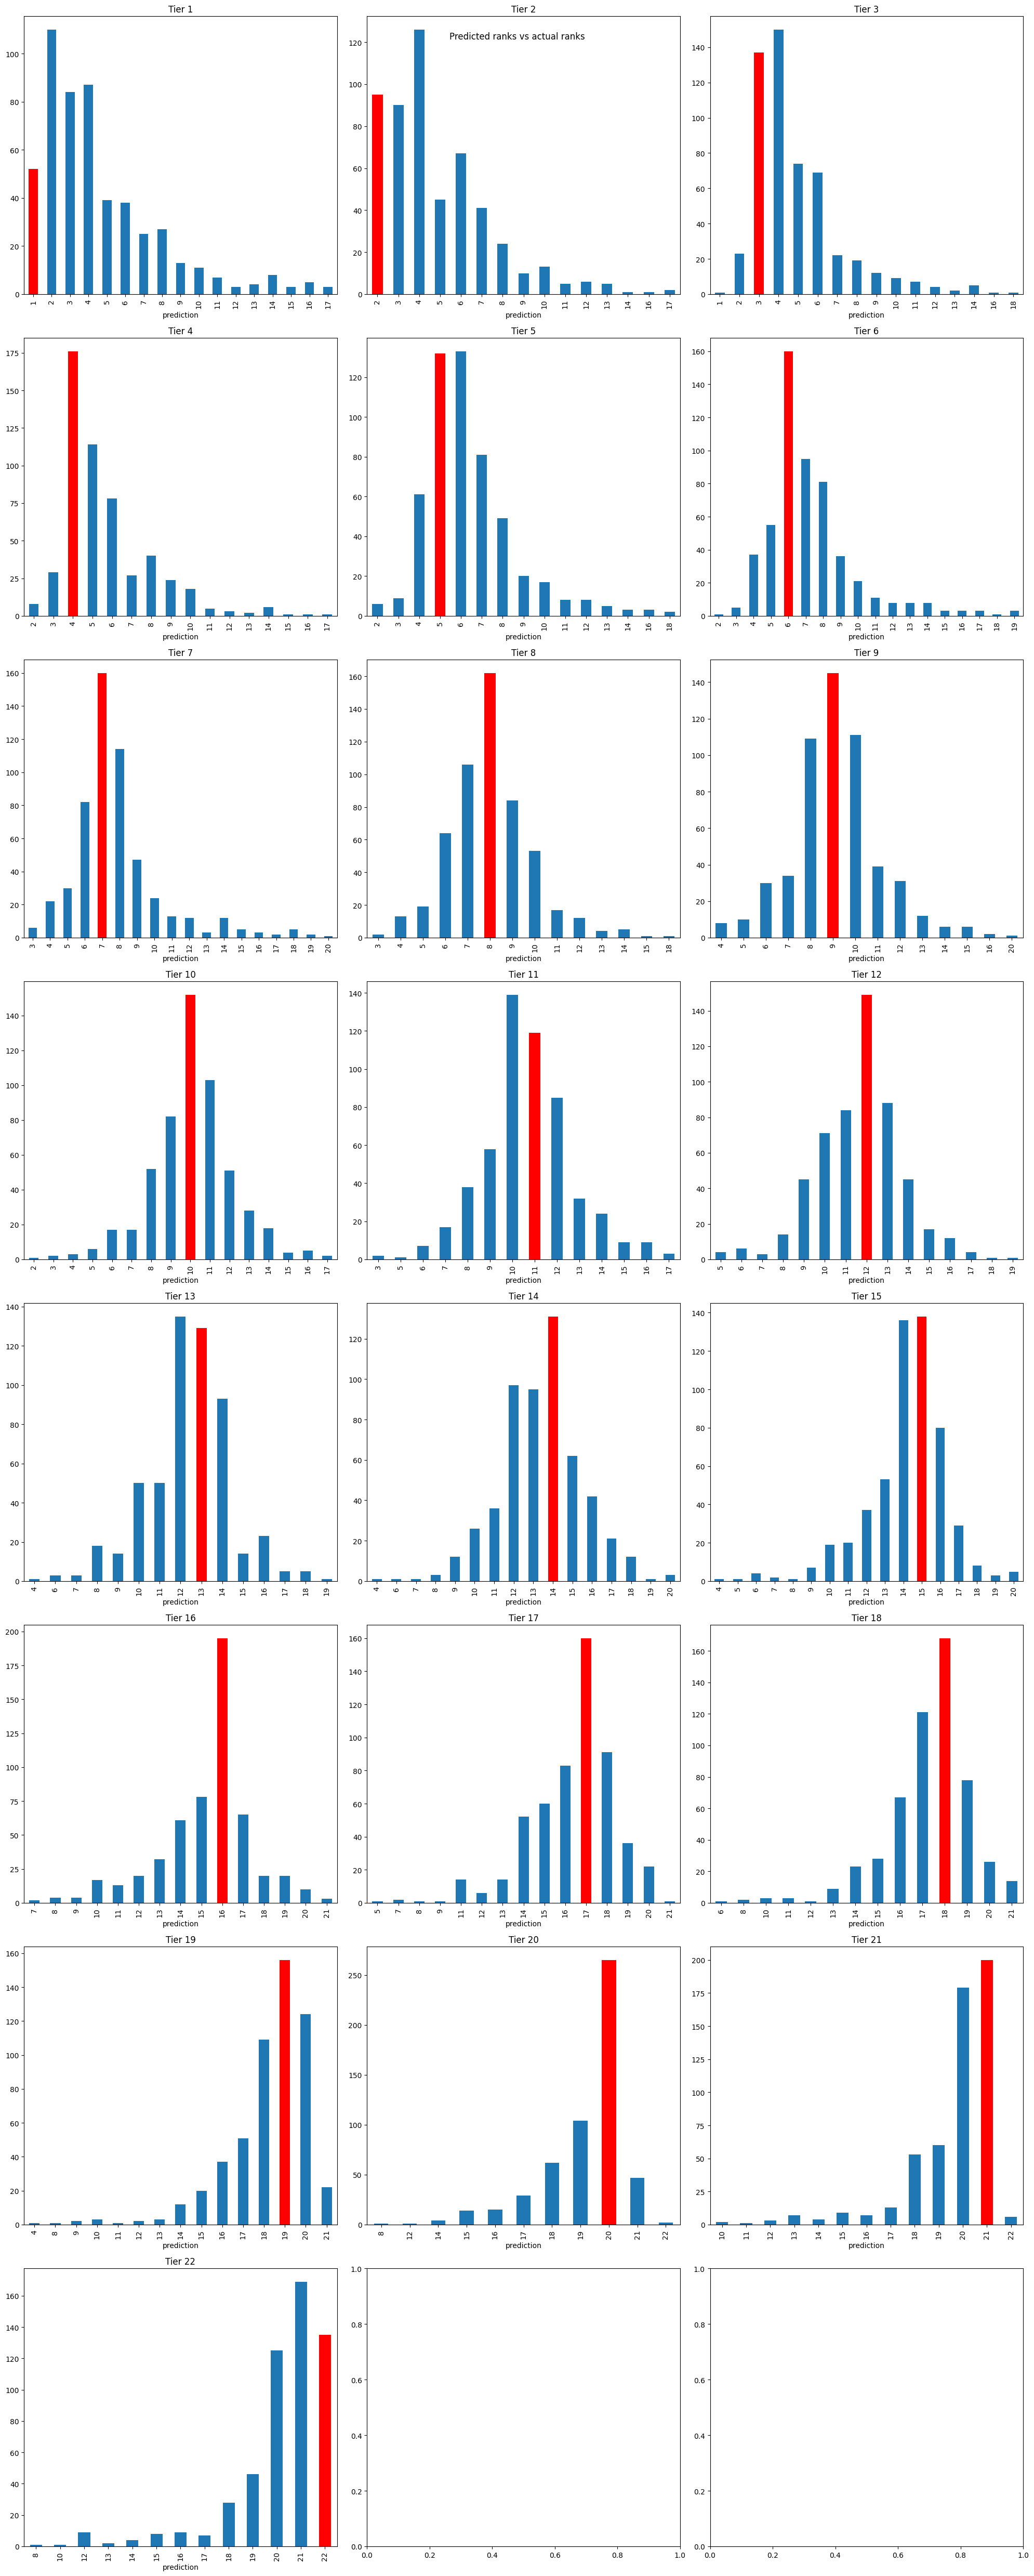

In [ ]:
fig, ax = plt.subplots(8, 3, figsize=(20, 50))

for i, tier in enumerate(range(1, 23)):
    df_tier = df[df['tier'] == tier]
    ax_ = ax[i // 3, i % 3]
    count = df_tier['prediction'].value_counts().sort_index()
    count.plot(kind='bar', ax=ax_, title=f'Tier {tier}')
    index = count.index.get_loc(tier)
    ax_.patches[index].set_facecolor('r')

fig.suptitle('Predicted ranks vs actual ranks')
plt.tight_layout()

In [ ]:
tags = defaultdict(int)
for r in replays:
    for team in ['blue', 'orange']:
        for player in r[team]['players']:
            if 'predict' not in player: continue
            for tag in player['predict']['tags']:
                tags[tag['name']] += 1

In [ ]:
tags = sorted(tags.items(), key=lambda x: x[1], reverse=True)
total = len(replays) * len(replays[0]['blue']['players']) * 2
print(f'Total replays: {len(replays)}')
print(f'Total players: {total}')
print('====================')
for tag, count in tags:
    print(f'{tag}: {count} = {count / total * 100:.2f}%')

Total replays: 2992
Total players: 11968
Winner: 5958 = 49.78%
Analyzer MVP: 2992 = 25.00%
MVP: 2928 = 24.47%
Striker: 1999 = 16.70%
Goalkeaper: 1633 = 13.64%
Playmaker: 1524 = 12.73%
Smurf ?: 385 = 3.22%
